<a href="https://colab.research.google.com/github/ykchong45/jetson-tracking-person/blob/main/CenterNet_0.02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Object Detection Colab

Welcome to the object detection colab!  This demo will take you through the steps of running an "out-of-the-box" detection model on a collection of images.

## Imports and Setup

In [1]:
# !pip install -U --pre tensorflow=="2.2.0"

In [2]:
%%time
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

CPU times: user 118 µs, sys: 19 µs, total: 137 µs
Wall time: 144 µs


In [3]:
# Install the Object Detection API
%%time
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624302 sha256=f8511df1f7bbf3a4d1fdaf1f71371be932754ef1dd53c90c28d59407ea524fe6
  Stored in directory: /tmp/pip-ephem-wheel-cache-i76a927d/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1
CPU times: user 71.2 ms, sys: 11.4 ms, total: 82.5 ms
Wall time: 5.42 s


In [4]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import time
class timeit():
    from datetime import datetime
    def __init__(self, name=''):
        self.name = name
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime {}: {}'.format(self.name, self.datetime.now() - self.tic))

%matplotlib inline

## Utilities

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [6]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8', 'pipeline': 'pipeline'}

model_display_name = 'pipeline' # @param ['centernet_with_keypoints', 'centernet_without_keypoints', 'pipeline']
model_name = MODELS[model_display_name]

### Build a detection model and load pre-trained model weights

This sometimes takes a little while, please be patient!

In [7]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

# if model_display_name == 'centernet_with_keypoints':
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#   !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
#   !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
# else:
#   !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
#   !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
#   !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
%%time
# Keypoint Center
!wget http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_kpts.tar.gz
!tar -xf centernet_mobilenetv2fpn_512x512_coco17_kpts.tar.gz
!mv centernet_mobilenetv2_fpn_kpts/checkpoint/* centernet_mobilenetv2_fpn_kpts/saved_model/

# # No Keypoint Centernet
# !wget http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz
# !tar -xf centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz 
# !mv ./centernet_mobilenetv2_fpn_od ./centernet_mobilenetv2_fpn_kpts
# !mv centernet_mobilenetv2_fpn_kpts/checkpoint/* centernet_mobilenetv2_fpn_kpts/saved_model/

--2021-03-09 14:48:59--  http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_kpts.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.107.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.107.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44635028 (43M) [application/x-tar]
Saving to: ‘centernet_mobilenetv2fpn_512x512_coco17_kpts.tar.gz.1’

centernet_mobilenet 100%[===================>]  42.57M   120MB/s    in 0.4s    

2021-03-09 14:49:00 (120 MB/s) - ‘centernet_mobilenetv2fpn_512x512_coco17_kpts.tar.gz.1’ saved [44635028/44635028]

CPU times: user 22.5 ms, sys: 24.3 ms, total: 46.8 ms
Wall time: 1.38 s


In [8]:
%%bash

ls 

centernet_mobilenetv2fpn_512x512_coco17_kpts.tar.gz
centernet_mobilenetv2fpn_512x512_coco17_kpts.tar.gz.1
centernet_mobilenetv2_fpn_kpts
models
sample_data
ZED_HD720_person.avi


In [9]:
pipeline_config = os.path.join('centernet_mobilenetv2_fpn_kpts/',
                                'pipeline' + '.config')
model_dir = 'centernet_mobilenetv2_fpn_kpts/saved_model'

# Configurer Path_to_be_configured
!sed -i 's/PATH_TO_BE_CONFIGURED/centernet_mobilenetv2_fpn_kpts/g'  centernet_mobilenetv2_fpn_kpts/pipeline.config

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
# for k,v in configs.items():
#     print("v",v)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-301')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [10]:
# m = tf.saved_model.load('centernet_mobilenetv2_fpn_kpts/saved_model')



# Load label map data (for plotting).

Label maps correspond index numbers to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [11]:
# configs = config_util.get_configs_from_pipeline_file(pipeline_config)
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### Putting everything together!

Run the below code which loads an image, runs it through the detection model and visualizes the detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to tf.function's trace-compilation --- on subsequent runs (e.g. on new images), things will be faster.

Here are some simple things to try out if you are curious:
* Try running inference on your own images (local paths work)
* Modify some of the input images and see if detection still works.  Some simple things to try out here (just uncomment the relevant portions of code) include flipping the image horizontally, or converting to grayscale (note that we still expect the input image to have 3 channels).
* Print out `detections['detection_boxes']` and try to match the box locations to the boxes in the image.  Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).
* Set min_score_thresh to other values (between 0 and 1) to allow more detections in or to filter out more detections.

Note that you can run this cell repeatedly without rerunning earlier cells.


In [12]:
from object_detection.utils import visualization_utils as viz_utils

In [13]:
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                            #    font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

#   # If the total height of the display strings added to the top of the bounding
#   # box exceeds the top of the image, stack the strings below the bounding box
#   # instead of above.
#   display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
#   # Each display_str has a top and bottom margin of 0.05x.
#   total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

#   if top > total_display_str_height:
#     text_bottom = top
#   else:
#     text_bottom = top + total_display_str_height
#   # Reverse list and print from bottom to top.
#   for display_str in display_str_list[::-1]:
#     text_width, text_height = font.getsize(display_str)
#     margin = np.ceil(0.05 * text_height)
#     draw.rectangle([(left, text_bottom - text_height - 2 * margin),
#                     (left + text_width, text_bottom)],
#                    fill=color)
#     draw.text((left + margin, text_bottom - text_height - margin),
#               display_str,
#               fill="black",
#               font=font)
#     text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.3):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  cnt = 0
  for i in range(min(boxes.shape[0], max_boxes)):
    if class_names[i] != 1:
        continue
    cnt += 1
    if cnt == 2:
        break
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(category_index[class_names[i]]['name'],
                                     int(100 * scores[i]))
    #   color = colors[hash(class_names[i]*100) % len(colors)]
      color = 'blue'
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
        #   font,
          display_str_list=[display_str])

    #   draw = ImageDraw.Draw(image_pil)
    #   im_width, im_height = image_pil.size
    #   (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
    #                             ymin * im_height, ymax * im_height)
    #   draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
    #          (left, top)],
    #         width=4,
    #         fill=color)

      np.copyto(image, np.array(image_pil))
  return image

runtime loadImage: 0:00:01.611408
runtime toTensor: 0:00:00.002874
Instructions for updating:
Use `tf.cast` instead.
Inference time:  9.891165494918823
runtime postProcessing: 0:00:00.001999
runtime vis: 0:00:00.014762


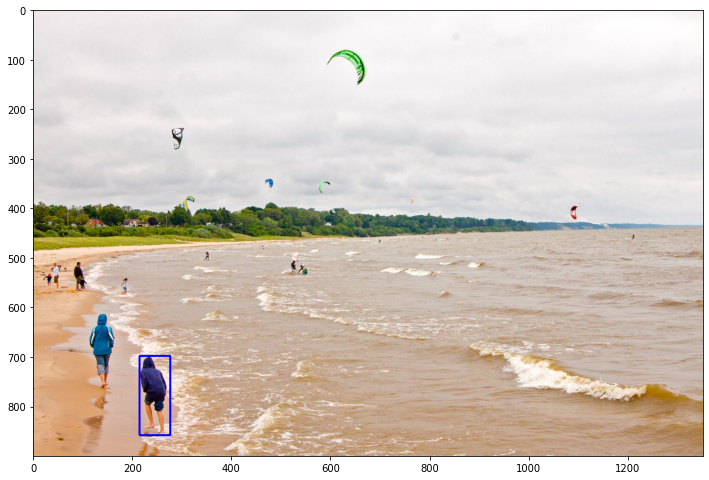

In [14]:
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')

with timeit('loadImage'):
    image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
with timeit('toTensor'):
    input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)

start = time.time()
detections, predictions_dict, shapes = detect_fn(input_tensor)
end = time.time()
print("Inference time: ", end-start)

with timeit('postProcessing'):
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    # Use keypoints if available in detections
    keypoints, keypoint_scores = None, None
    # if 'detection_keypoints' in detections:
    #     keypoints = detections['detection_keypoints'][0].numpy()
    #     keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

with timeit('vis'):
    draw_boxes(image_np_with_detections,
           detections['detection_boxes'][0].numpy(),
           (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
           detections['detection_scores'][0].numpy(),
           max_boxes=10,
           min_score=0.3
           )

    # viz_utils.visualize_boxes_and_labels_on_image_array(
    # image_np_with_detections,
    # detections['detection_boxes'][0].numpy(),
    # (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
    # detections['detection_scores'][0].numpy(),
    # category_index,
    # use_normalized_coordinates=True,
    # max_boxes_to_draw=20,
    # min_score_thresh=.30,
    # agnostic_mode=False
    # # keypoints=keypoints,
    # # keypoint_scores=keypoint_scores,
    # # keypoint_edges=get_keypoint_tuples(configs['eval_config'])
    # )

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

Load video

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

capture = cv2.VideoCapture('ZED_HD720_person.avi')
while True:
    ret, frame = capture.read()
    # image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # cv2_imshow(frame)
    # clear_output(wait=True)

## Digging into the model's intermediate predictions

For this part we will assume that the detection model is a CenterNet model following Zhou et al (https://arxiv.org/abs/1904.07850).  And more specifically, we will assume that `detection_model` is of type `meta_architectures.center_net_meta_arch.CenterNetMetaArch`.

As one of its intermediate predictions, CenterNet produces a heatmap of box centers for each class (for example, it will produce a heatmap whose size is proportional to that of the image that lights up at the center of each, e.g., "zebra"). In the following, we will visualize these intermediate class center heatmap predictions.

In [ ]:
if detection_model.__class__.__name__ != 'CenterNetMetaArch':
  raise AssertionError('The meta-architecture for this section '
  'is assumed to be CenterNetMetaArch!')

def get_heatmap(predictions_dict, class_name):
  """Grabs class center logits and apply inverse logit transform.

  Args:
    predictions_dict: dictionary of tensors containing a `object_center`
      field of shape [1, heatmap_width, heatmap_height, num_classes]
    class_name: string name of category (e.g., `horse`)

  Returns:
    heatmap: 2d Tensor heatmap representing heatmap of centers for a given class
      (For CenterNet, this is 128x128 or 256x256) with values in [0,1]
  """
  class_index = label_map_dict[class_name]
  class_center_logits = predictions_dict['object_center'][0]
  class_center_logits = class_center_logits[0][
    :, :, class_index - label_id_offset]
  heatmap = tf.exp(class_center_logits) / (tf.exp(class_center_logits) + 1)
  return heatmap

def unpad_heatmap(heatmap, image_np):
  """Reshapes/unpads heatmap appropriately.

  Reshapes/unpads heatmap appropriately to match image_np.

  Args:
    heatmap: Output of `get_heatmap`, a 2d Tensor
    image_np: uint8 numpy array with shape (img_height, img_width, 3).  Note
      that due to padding, the relationship between img_height and img_width
      might not be a simple scaling.

  Returns:
    resized_heatmap_unpadded: a resized heatmap (2d Tensor) that is the same
      size as `image_np`
  """
  heatmap = tf.tile(tf.expand_dims(heatmap, 2), [1, 1, 3]) * 255
  pre_strided_size = detection_model._stride * heatmap.shape[0]
  resized_heatmap = tf.image.resize(
      heatmap, [pre_strided_size, pre_strided_size],
      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  resized_heatmap_unpadded = tf.slice(resized_heatmap, begin=[0,0,0], size=shapes)
  return tf.image.resize(
      resized_heatmap_unpadded,
      [image_np.shape[0], image_np.shape[1]],
      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)[:,:,0]


class_name = 'kite'
heatmap = get_heatmap(predictions_dict, class_name)
resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np)
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
plt.title('Object center heatmap (class: ' + class_name + ')')
plt.show()

class_name = 'person'
heatmap = get_heatmap(predictions_dict, class_name)
resized_heatmap_unpadded = unpad_heatmap(heatmap, image_np)
plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.imshow(resized_heatmap_unpadded, alpha=0.7,vmin=0, vmax=160, cmap='viridis')
plt.title('Object center heatmap (class: ' + class_name + ')')
plt.show()

InvalidArgumentError: ignored